In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

In [2]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

In [3]:
flies = ['fly_087', 'fly_089', 'fly_094', 'fly_095', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']

In [37]:
z=20
superslice = np.zeros((256,128,3384,10))
for i, fly in enumerate(flies):
    print(i)
    file = os.path.join(dataset_path, fly, 'func_0', 'brain_zscored_green_high_pass_masked_warped.nii')
    t0=time.time()
    superslice[:,:,:,i] = np.array(nib.load(file).get_data(), copy=True)[:,:,z,:]
    print(time.time()-t0)

0
61.04122352600098
1
32.94138479232788
2
33.85438942909241
3
37.54546642303467
4
34.09383797645569
5
46.34052491188049
6
34.36810874938965
7
36.885475873947144
8
39.62551498413086
9
42.07742500305176


In [40]:
nib.Nifti1Image(superslice, np.eye(4)).to_filename(os.path.join(clustering_dir, 'superslice_20.nii'))

In [130]:
superslice.shape

(256, 128, 3384, 10)

In [42]:
connectivity = grid_to_graph(256,128)

In [39]:
clustering_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201110_analysis_superfly_supervoxels"
if not os.path.exists(clustering_dir):
        os.mkdir(clustering_dir)

In [175]:
super_to_cluster = superslice.reshape(-1, 33840)

In [176]:
super_to_cluster.shape

(32768, 33840)

In [131]:
super_to_cluster = superslice[:,:,:,0].reshape(-1, 3384)
print(super_to_cluster.shape)

(32768, 3384)


In [177]:
n_clusters = 2000 #2000
model = AgglomerativeClustering(n_clusters=n_clusters,
                                memory=clustering_dir,
                                linkage='ward',
                                connectivity=connectivity)
model = model.fit(super_to_cluster)

In [133]:
signals = []
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    mean_signal = np.mean(super_to_cluster[cluster_indicies,:], axis=0)
    signals.append(mean_signal)
signals=np.asarray(signals)

In [134]:
signals.shape

(2000, 3384)

In [64]:
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    colored_by_betas[cluster_indicies] = np.random.randint(1,100) #assign corrs here instead.
    #colored_by_betas[cluster_indicies] = corrs[cluster_num] #assign corrs here instead.
colored_by_betas = colored_by_betas.reshape(256,128)

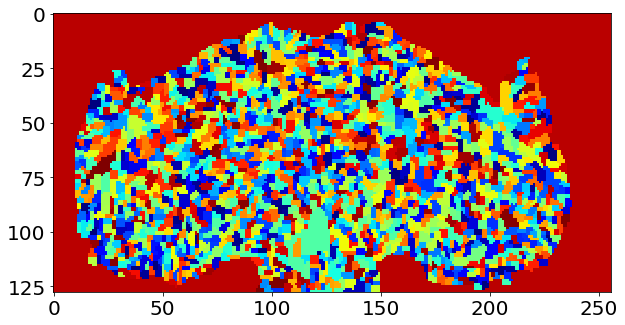

In [53]:
plt.figure(figsize=(10,10))
plt.imshow(colored_by_betas.T,cmap='jet')

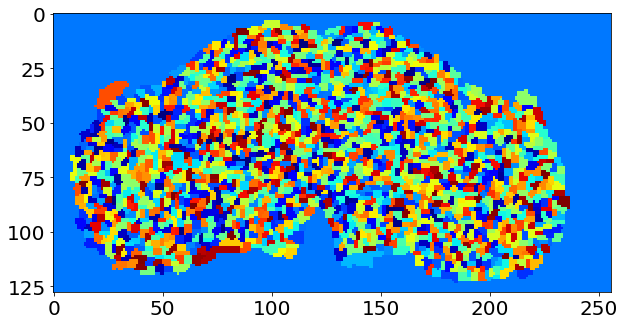

In [61]:
plt.figure(figsize=(10,10))
plt.imshow(colored_by_betas.T,cmap='jet')

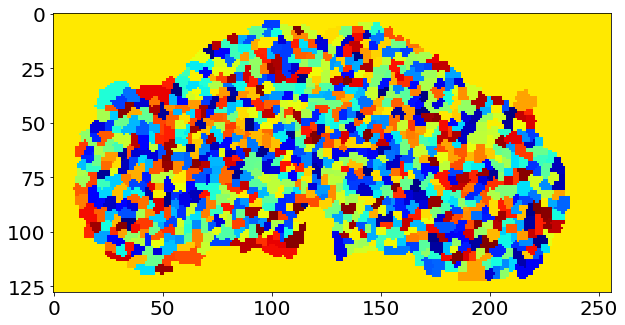

In [65]:
plt.figure(figsize=(10,10))
plt.imshow(colored_by_betas.T,cmap='jet')

# Make super-behavior trace

In [66]:
def make_interp_object(fictrac_raw, behavior):
    # Create camera timepoints
    fps=50
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    expt_len = 1000*30*60
    x_original = np.arange(0,expt_len,camera_rate)
    
    # Smooth raw fictrac data
    fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(fictrac_raw[behavior]),25,3)
    
    # Create interp object with camera timepoints
    fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    return fictrac_interp_object

def pull_from_interp_object(interp_object, timepoints):
    new_interp = interp_object(timepoints)
    np.nan_to_num(new_interp, copy=False);
    return new_interp

def interp_fictrac(z):
    behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
    fictrac = {}

    for behavior, short in zip(behaviors, shorts):
        interp_object = make_interp_object(fictrac_raw, behavior)
        fictrac[short + 'i'] = interp_object

        ### Velocity ###
        low_res_behavior = pull_from_interp_object(interp_object, timestamps[:,z])
        fictrac[short] = low_res_behavior/np.std(low_res_behavior)

        ### Acceleration ###
        high_res_behavior = pull_from_interp_object(interp_object, high_res_timepoints)
        fictrac[short + 'h'] = high_res_behavior/np.std(high_res_behavior)

        accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
        accel = np.append(accel, 0)
        interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
        acl = interp_object(timestamps[:,z])
        acl[-1] = 0
        fictrac[short + 'a'] = acl/np.std(acl)

    fictrac['YZ'] = np.sqrt(np.power(fictrac['Y'],2), np.power(fictrac['Z'],2))
    fictrac['YZh'] = np.sqrt(np.power(fictrac['Yh'],2), np.power(fictrac['Zh'],2))
    
    return fictrac

In [68]:
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

fictracs = []
for fly in flies:
    directory = os.path.join(dataset_path,fly,'func_0')
    timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
    fictrac_raw = bbb.load_fictrac(os.path.join(directory, 'fictrac'))
    fictracs.append(interp_fictrac(z=20))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 3.24 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.98 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 48.16 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.16 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 49.93 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.14 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 76.74 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.16 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 53.59 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.21 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 35.52 

In [77]:
forwards = np.array([i['Y'] for i in fictracs])

In [78]:
forwards.shape

(10, 3384)

In [85]:
super_forward = forwards.flatten()

In [86]:
super_forward.shape

(33840,)

array([    0,  3384,  6768, 10152, 13536, 16920, 20304, 23688, 27072,
       30456])

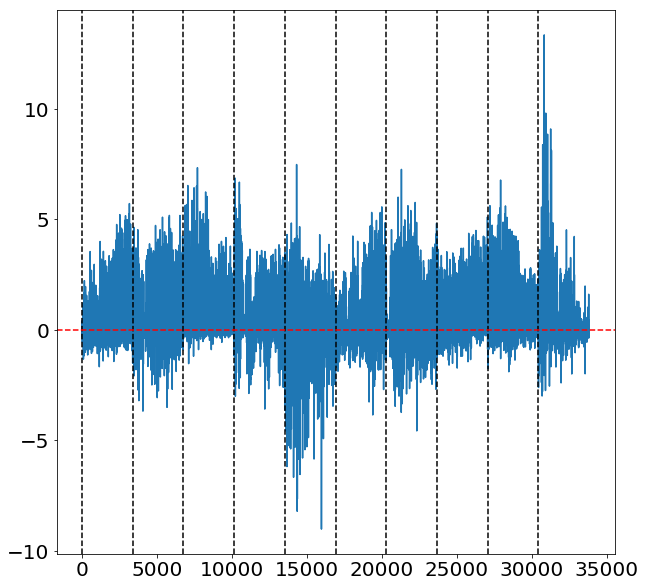

In [112]:
plt.figure(figsize=(10,10))
plt.plot(super_forward)
for x in np.arange(0,33840,3384):
    plt.axvline(x,color='k',linestyle='--')
plt.axhline(0,color='r',linestyle='--')

In [95]:
signals.shape

(2000, 33840)

In [113]:
flies

['fly_087',
 'fly_089',
 'fly_094',
 'fly_095',
 'fly_097',
 'fly_098',
 'fly_099',
 'fly_100',
 'fly_101',
 'fly_105']

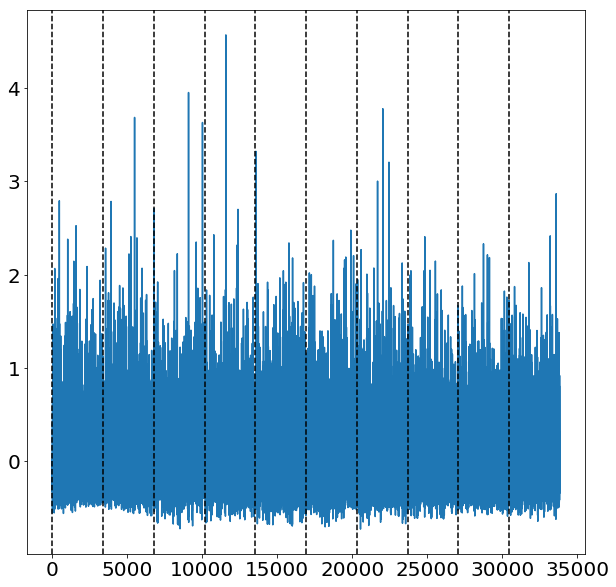

In [122]:
plt.figure(figsize=(10,10))
plt.plot(signals[100,:])
for x in np.arange(0,33840,3384):
    plt.axvline(x,color='k',linestyle='--')

In [135]:
signals.shape

(2000, 3384)

In [136]:
corrs = []
for i in range(n_clusters):
    corrs.append(scipy.stats.pearsonr(super_forward[:3384], signals[i,:])[0])

In [137]:
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    #colored_by_betas[cluster_indicies] = np.random.randint(1,100) #assign corrs here instead.
    colored_by_betas[cluster_indicies] = corrs[cluster_num] #assign corrs here instead.
colored_by_betas = colored_by_betas.reshape(256,128)

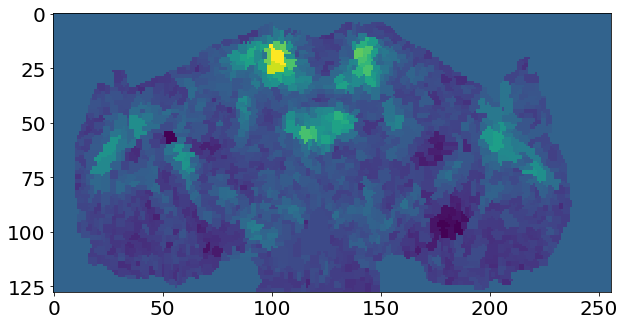

In [138]:
plt.figure(figsize=(10,10))
plt.imshow(colored_by_betas.T)

In [141]:
np.max(corrs)

0.454922929633166

In [152]:
flies[1]

'fly_089'

In [153]:
#get single-fly signals, each fly makes its own supervoxels
single_maps = []
for fly_idx in range(10):
    print(flies[fly_idx])
    super_to_cluster = superslice[:,:,:,fly_idx].reshape(-1, 3384)

    n_clusters = 2000
    model = AgglomerativeClustering(n_clusters=n_clusters,
                                    memory=clustering_dir,
                                    linkage='ward',
                                    connectivity=connectivity)
    model = model.fit(super_to_cluster)

    signals = []
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(model.labels_==cluster_num)[0]
        mean_signal = np.mean(super_to_cluster[cluster_indicies,:], axis=0)
        signals.append(mean_signal)
    signals=np.asarray(signals)

    corrs = []
    for i in range(n_clusters):
        corrs.append(scipy.stats.pearsonr(forwards[fly_idx,:], signals[i,:])[0])

    colored_by_betas = np.zeros(256*128)
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(model.labels_==cluster_num)[0]
        colored_by_betas[cluster_indicies] = corrs[cluster_num] #assign corrs here instead.
    colored_by_betas = colored_by_betas.reshape(256,128)
    single_maps.append(colored_by_betas)

fly_087
fly_089
fly_094
fly_095
fly_097
fly_098
fly_099
fly_100
fly_101
fly_105


In [182]:
#get single-fly signals, all share same super voxels
super_to_cluster = superslice.reshape(-1, 33840)
n_clusters = 100
model = AgglomerativeClustering(n_clusters=n_clusters,
                                memory=clustering_dir,
                                linkage='ward',
                                connectivity=connectivity)
model = model.fit(super_to_cluster)

single_maps_shared_clusters = []
for fly_idx in range(10):
    print(flies[fly_idx])
    neural_data = superslice[:,:,:,fly_idx].reshape(-1, 3384)

    signals = []
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(model.labels_==cluster_num)[0]
        mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
        signals.append(mean_signal)
    signals=np.asarray(signals)

    corrs = []
    for i in range(n_clusters):
        corrs.append(scipy.stats.pearsonr(forwards[fly_idx,:], signals[i,:])[0])

    colored_by_betas = np.zeros(256*128)
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(model.labels_==cluster_num)[0]
        colored_by_betas[cluster_indicies] = corrs[cluster_num] #assign corrs here instead.
    colored_by_betas = colored_by_betas.reshape(256,128)
    single_maps_shared_clusters.append(colored_by_betas)

fly_087
fly_089
fly_094
fly_095
fly_097
fly_098
fly_099
fly_100
fly_101
fly_105


In [184]:
signals.shape

(100, 3384)

In [163]:
flies[0]

'fly_087'

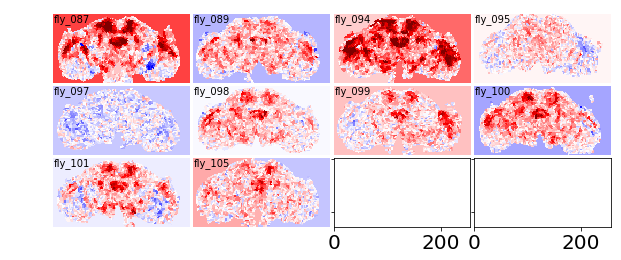

In [174]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=.05)
for i in range(10):
    grid[i].imshow(single_maps[i].T,vmin=-.2,vmax=.2,cmap='seismic')
    grid[i].axis('off')
    grid[i].set_title(flies[i],fontsize=10,x=.14,y=.8)
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
plt.savefig(fname,dpi=300,bbox_inches='tight')

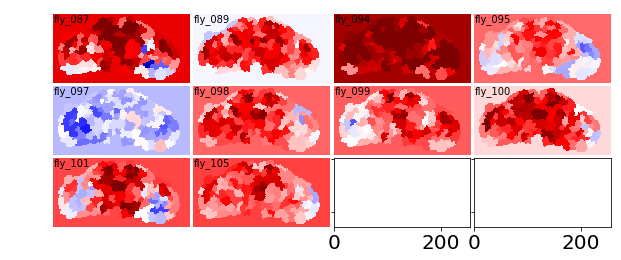

In [183]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=.05)
for i in range(10):
    grid[i].imshow(single_maps_shared_clusters[i].T,vmin=-.2,vmax=.2,cmap='seismic')
    grid[i].axis('off')
    grid[i].set_title(flies[i],fontsize=10,x=.14,y=.8)
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [185]:
super_to_cluster = superslice.reshape(-1, 33840)
n_clusters = 2000
model = AgglomerativeClustering(n_clusters=n_clusters,
                                memory=clustering_dir,
                                linkage='ward',
                                connectivity=connectivity)
model = model.fit(super_to_cluster)

In [186]:
superslice.shape

(256, 128, 3384, 10)

In [189]:
super_to_cluster.shape

(32768, 33840)

In [193]:
forwards = np.array([i['Y'] for i in fictracs])
super_forwards = forwards.swapaxes(0,1).reshape(-1)

In [210]:
forwards = np.array([np.clip(i['Z'], a_min=None, a_max=0) for i in fictracs])
super_forwards = forwards.swapaxes(0,1).reshape(-1)

In [211]:
signals = []
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    mean_signal = np.mean(super_to_cluster[cluster_indicies,:], axis=0)
    signals.append(mean_signal)
signals=np.asarray(signals)

corrs = []
for i in range(n_clusters):
    corrs.append(scipy.stats.pearsonr(super_forwards, signals[i,:])[0])

colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(model.labels_==cluster_num)[0]
    colored_by_betas[cluster_indicies] = corrs[cluster_num] #assign corrs here instead.
colored_by_betas = colored_by_betas.reshape(256,128)

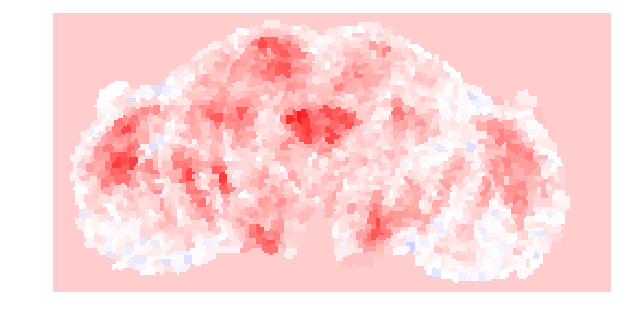

In [209]:
fig = plt.figure(figsize=(10,10))
plt.imshow(colored_by_betas.T,cmap='seismic',vmin=-.2,vmax=.2)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
plt.savefig(fname,dpi=300,bbox_inches='tight')

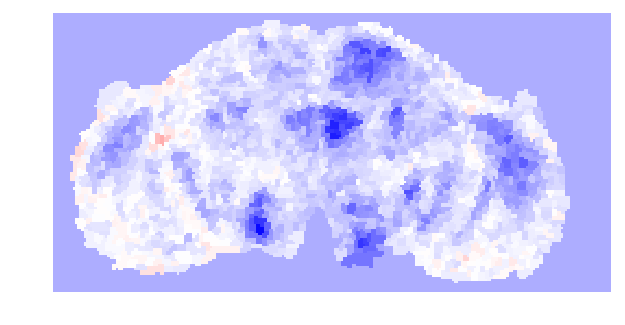

In [212]:
fig = plt.figure(figsize=(10,10))
plt.imshow(colored_by_betas.T,cmap='seismic',vmin=-.2,vmax=.2)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
plt.savefig(fname,dpi=300,bbox_inches='tight')